In [1]:
import numpy as np
from dolfinx.mesh import create_rectangle, CellType
from mpi4py import MPI
from pybandgap.set_structure import fine_irreducible_brillouin_zone, get_midpoint_elements, Material, Props, fine_symmetry_elements
from pybandgap.plot_mesh import plot_IBZ, plot_structure
from pybandgap.bandgap import bandgap
from pybandgap.mass_and_stiffness_matrix import matrix_and_stiffness_matrix

a = 20e-3
nx = 20
ny = nx
msh = create_rectangle(MPI.COMM_WORLD, np.array([[-a/2,-a/2],[a/2,a/2]]), [nx, ny], CellType.quadrilateral)

In [2]:
elements, IBZ_condition = fine_irreducible_brillouin_zone(msh)

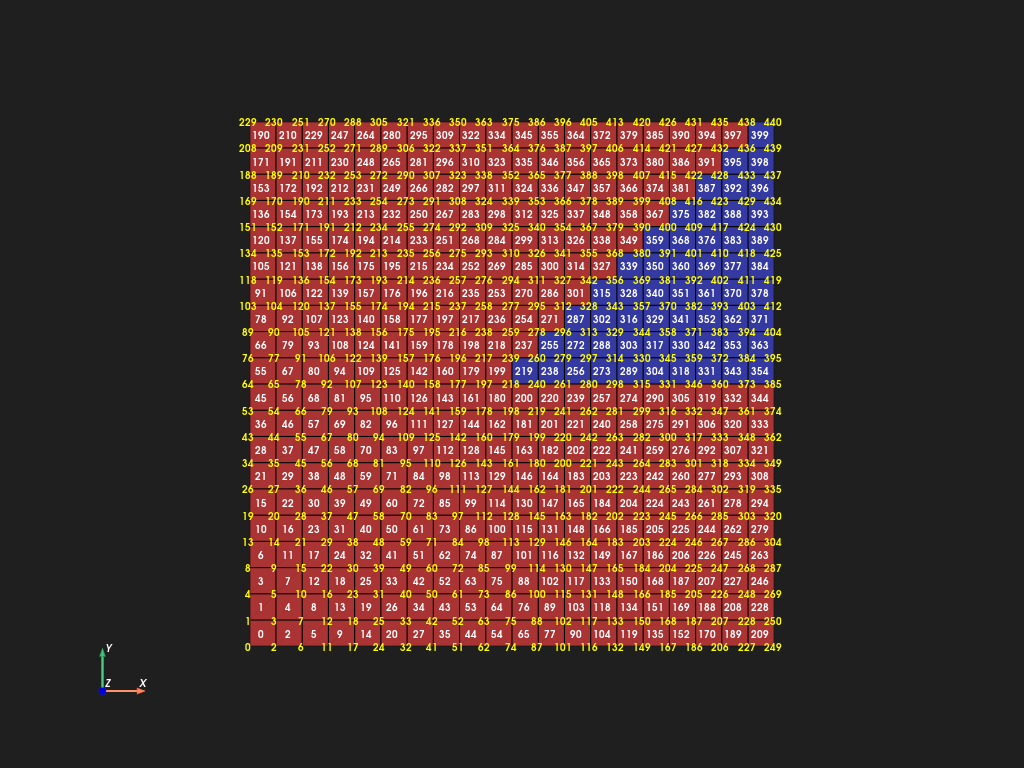

In [3]:
plot_IBZ(msh, elements)

In [4]:
centers = get_midpoint_elements(msh)

condition_1 = centers[:,0]<= a/4
condition_2 = centers[:,1]<= a/4

condition = np.vstack((IBZ_condition, condition_1, condition_2))

tungsten_elements = np.where(np.all(condition, axis=0))[0]

In [5]:
aluminio = Material('aluminio', young_modulus=70e9, poisson_ratio=0.33, density=2.7e3)
tungsteno = Material('tungsteno', young_modulus=411e9, poisson_ratio=0.28, density=19.3e3)

In [6]:
material_elements = np.array([
    tungsteno if i in tungsten_elements else aluminio
    for i in elements])

In [7]:
props = Props(msh)
props.set_prop('materials', material_elements)

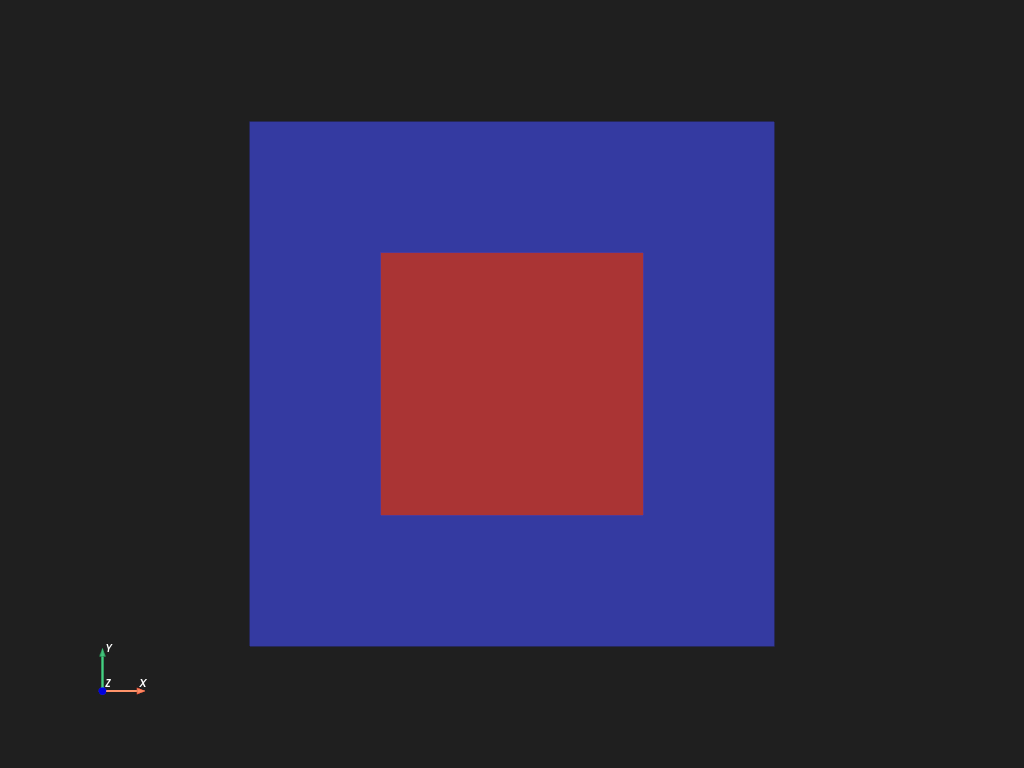

In [8]:
plot_structure(msh, props)

In [9]:
mass_matrix, stiffness_matrix = matrix_and_stiffness_matrix(msh, props)

In [10]:
E = tungsteno.young_modulus
nu = tungsteno.poisson_ratio
rho = tungsteno.density
mu = E / (2 * (1 + nu))

c_t = np.sqrt(mu / rho)

normalized = a / (2* np.pi * c_t)

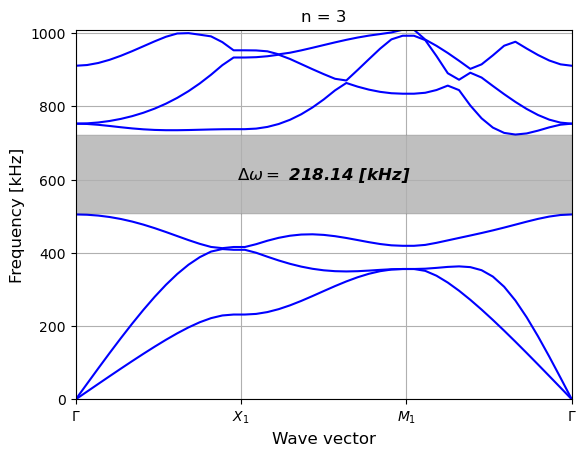

In [11]:
_ = bandgap(3, msh, mass_matrix, stiffness_matrix, N_eig = 6, plot= True, NINT=15, tol = 1e-10, max_it = 150, normalized= normalized)